In [1]:
import pandas as pd
import numpy as np
import pathlib
import ast
from datetime import datetime

In [2]:
datapath = pathlib.Path('C:/Users/vokon')
proj_folder = pathlib.Path('C:/Users/vokon/PycharmProjects/PythonProject3')

In [3]:
movie_df = pd.read_csv(datapath.joinpath('movie_df.csv'))
links = pd.read_csv(datapath.joinpath('ml-25m', 'links.csv'))


C:\Users\vokon\AppData\Local\Temp\ipykernel_27024\2057202850.py:1: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_df = pd.read_csv(datapath.joinpath('movie_df.csv'))


In [4]:
print(movie_df.shape[0])
movie_df=movie_df.dropna(subset=['name', 'persons', 'genres', 'description'])
print(movie_df.shape[0])

51933
28314


In [5]:
ratings = pd.read_csv(datapath.joinpath('ml-25m', 'ratings.csv'))

In [6]:
ratings['movieId'].unique().shape

(59047,)

In [7]:
review_df = pd.read_csv(datapath.joinpath('review_df.csv'))

In [8]:
ratings_kp = review_df[['authorId', 'movieId', 'type', 'date']].copy()
ratings_kp.loc[:,'type'] = ratings_kp['type'].map({'Позитивный':5, 'Нейтральный':3, 'Негативный':1})
# ratings_kp = ratings_kp[['authorId', 'movieId', 'type']]
ratings_kp.rename(columns={'type':'rating','authorId':'userId', 'date': 'timestamp'}, inplace=True)
ratings_kp['userId'] = ratings['userId'].max() + 100 + ratings_kp['userId']
ratings_kp = ratings_kp[ratings_kp.groupby('movieId').userId.transform('size') > 5]
ratings_kp = ratings_kp[ratings_kp.groupby('userId').movieId.transform('size') > 5]
ratings_kp['timestamp'] = pd.to_datetime(ratings_kp['timestamp'], format="%Y-%m-%d %H:%M:%S").dt.tz_localize(None)
ratings_kp

,userId,movieId,rating,timestamp
0,14403042.0,298,5,2024-03-31 22:12:20
1,2363839.0,298,5,2024-02-26 20:19:37
2,60534129.0,298,5,2023-05-04 04:43:37
3,14381370.0,298,5,2023-03-06 12:30:27
4,44242750.0,298,5,2022-11-15 12:52:27
...,...,...,...,...
154416,168183.0,28279,3,2008-01-29 23:50:05
154448,818517.0,28452,1,2024-01-31 13:42:34
154451,1696664.0,28452,3,2011-08-09 14:22:55
154454,172902.0,28452,3,2008-02-05 16:41:50


In [9]:
ratings_kp['movieId'].unique().shape

(4068,)

In [10]:
df = movie_df[['id', 'name', 'externalId']].copy()

In [11]:
df

,id,name,externalId
0,298,Люди Икс 2,"{'imdb': 'tt0290334', 'tmdb': 36658, 'kpHD': '..."
1,299,Матрица: Перезагрузка,"{'imdb': 'tt0234215', 'tmdb': 604, 'kpHD': '4f..."
2,300,Лиззи Магуайр,"{'imdb': 'tt0306841', 'tmdb': 18736, 'kpHD': '..."
3,301,Матрица,"{'imdb': 'tt0133093', 'tmdb': 603, 'kpHD': '48..."
4,302,Клад,"{'kpHD': '46b90c1024a5e40aa44db8b902976b5f', '..."
...,...,...,...
51916,54863,Пистолет,"{'imdb': None, 'kpHD': None}"
51919,54866,Слизни,"{'imdb': 'tt0093995', 'tmdb': 28452, 'kpHD': N..."
51926,54874,Замужество Марии Браун,"{'imdb': 'tt0079095', 'tmdb': 661, 'kpHD': None}"
51927,54875,В год тринадцати лун,"{'imdb': 'tt0077729', 'tmdb': 42206, 'kpHD': N..."


In [12]:
def get_imdbId(externalId, idtype):
    externalId = ast.literal_eval(externalId)
    try:
        if idtype == 'imdb':
            return externalId[idtype][2::]
        else:
            return externalId[idtype]
    except:
        return 0

In [13]:
df['imdbId'] = df['externalId'].apply(lambda x: get_imdbId(x, idtype='imdb'))
df['imdbId'] = pd.to_numeric(df['imdbId'], errors='coerce')
df['imdbId'] = df['imdbId'].fillna(0)
df['tmdbId'] = df['externalId'].apply(lambda x: get_imdbId(x, idtype='tmdb'))
df['tmdbId'] = df['tmdbId'].fillna(0)
df.shape

(28314, 5)

In [ ]:
# df[df['imdbId']==0]

In [14]:
links_with_kpIds=pd.merge(df, links, right_on=['imdbId'], left_on='imdbId', how='right')
links_with_kpIds=links_with_kpIds.drop(columns=['tmdbId_y'])
links_with_kpIds=links_with_kpIds.rename(columns = {'tmdbId_x':'tmdb'})
links_with_kpIds

,id,name,externalId,imdbId,tmdb,movieId
0,482.0,История игрушек,"{'imdb': 'tt0114709', 'tmdb': 862, 'kpHD': '46...",114709.0,862.0,1
1,8161.0,Джуманджи,"{'imdb': 'tt0113497', 'tmdb': 8844, 'kpHD': '4...",113497.0,8844.0,2
2,2734.0,Старые ворчуны разбушевались,"{'imdb': 'tt0113228', 'tmdb': 15602, 'kpHD': N...",113228.0,15602.0,3
3,4784.0,В ожидании выдоха,"{'imdb': 'tt0114885', 'tmdb': 31357, 'kpHD': N...",114885.0,31357.0,4
4,5133.0,Отец невесты 2,"{'imdb': 'tt0113041', 'tmdb': 11862, 'kpHD': '...",113041.0,11862.0,5
...,...,...,...,...,...,...
62429,NaN,NaN,NaN,6671244.0,NaN,209157
62430,NaN,NaN,NaN,297986.0,NaN,209159
62431,NaN,NaN,NaN,6755366.0,NaN,209163
62432,NaN,NaN,NaN,249603.0,NaN,209169


In [15]:
links_with_kpIds.dropna()

,id,name,externalId,imdbId,tmdb,movieId
0,482.0,История игрушек,"{'imdb': 'tt0114709', 'tmdb': 862, 'kpHD': '46...",114709.0,862.0,1
1,8161.0,Джуманджи,"{'imdb': 'tt0113497', 'tmdb': 8844, 'kpHD': '4...",113497.0,8844.0,2
2,2734.0,Старые ворчуны разбушевались,"{'imdb': 'tt0113228', 'tmdb': 15602, 'kpHD': N...",113228.0,15602.0,3
3,4784.0,В ожидании выдоха,"{'imdb': 'tt0114885', 'tmdb': 31357, 'kpHD': N...",114885.0,31357.0,4
4,5133.0,Отец невесты 2,"{'imdb': 'tt0113041', 'tmdb': 11862, 'kpHD': '...",113041.0,11862.0,5
...,...,...,...,...,...,...
62373,51787.0,"Карлота Жоакина, принцесса бразильская","{'kpHD': None, 'imdb': 'tt0109380', 'tmdb': 12...",109380.0,126045.0,208901
62386,46539.0,"Мария, Мирабела","{'kpHD': '4209e1ad7aea5d72b9d90fb07d064e0a', '...",155858.0,75372.0,208941
62405,6623.0,Второй шанс,"{'tmdb': 105427, 'kpHD': None, 'imdb': 'tt0272...",272125.0,105427.0,209069
62412,40786.0,Царь Иван Грозный,"{'kpHD': None, 'imdb': 'tt0103134', 'tmdb': 38...",103134.0,389979.0,209103


In [ ]:
# links_with_kpIds[links_with_kpIds['movieId']==296]
# df[df['id']==342]

In [16]:
links_with_kpIds=pd.merge(df, links, right_on=['tmdbId'], left_on='tmdbId', how='right')
links_with_kpIds=links_with_kpIds.drop(columns=['imdbId_y'])
links_with_kpIds.rename(columns = {'imdbId_x':'imdb'})
# links_with_kpIds=links_with_kpIds[['id', 'movieId']]

,id,name,externalId,imdb,tmdbId,movieId
0,482.0,История игрушек,"{'imdb': 'tt0114709', 'tmdb': 862, 'kpHD': '46...",114709.0,862.0,1
1,8161.0,Джуманджи,"{'imdb': 'tt0113497', 'tmdb': 8844, 'kpHD': '4...",113497.0,8844.0,2
2,2734.0,Старые ворчуны разбушевались,"{'imdb': 'tt0113228', 'tmdb': 15602, 'kpHD': N...",113228.0,15602.0,3
3,4784.0,В ожидании выдоха,"{'imdb': 'tt0114885', 'tmdb': 31357, 'kpHD': N...",114885.0,31357.0,4
4,5133.0,Отец невесты 2,"{'imdb': 'tt0113041', 'tmdb': 11862, 'kpHD': '...",113041.0,11862.0,5
...,...,...,...,...,...,...
62461,NaN,NaN,NaN,NaN,499546.0,209157
62462,NaN,NaN,NaN,NaN,63407.0,209159
62463,NaN,NaN,NaN,NaN,553036.0,209163
62464,NaN,NaN,NaN,NaN,162892.0,209169


In [17]:
links_with_kpIds.dropna()

,id,name,externalId,imdbId_x,tmdbId,movieId
0,482.0,История игрушек,"{'imdb': 'tt0114709', 'tmdb': 862, 'kpHD': '46...",114709.0,862.0,1
1,8161.0,Джуманджи,"{'imdb': 'tt0113497', 'tmdb': 8844, 'kpHD': '4...",113497.0,8844.0,2
2,2734.0,Старые ворчуны разбушевались,"{'imdb': 'tt0113228', 'tmdb': 15602, 'kpHD': N...",113228.0,15602.0,3
3,4784.0,В ожидании выдоха,"{'imdb': 'tt0114885', 'tmdb': 31357, 'kpHD': N...",114885.0,31357.0,4
4,5133.0,Отец невесты 2,"{'imdb': 'tt0113041', 'tmdb': 11862, 'kpHD': '...",113041.0,11862.0,5
...,...,...,...,...,...,...
62405,51787.0,"Карлота Жоакина, принцесса бразильская","{'kpHD': None, 'imdb': 'tt0109380', 'tmdb': 12...",109380.0,126045.0,208901
62418,46539.0,"Мария, Мирабела","{'kpHD': '4209e1ad7aea5d72b9d90fb07d064e0a', '...",155858.0,75372.0,208941
62437,6623.0,Второй шанс,"{'tmdb': 105427, 'kpHD': None, 'imdb': 'tt0272...",272125.0,105427.0,209069
62444,40786.0,Царь Иван Грозный,"{'kpHD': None, 'imdb': 'tt0103134', 'tmdb': 38...",103134.0,389979.0,209103


In [18]:
(pd.merge(ratings, links_with_kpIds.dropna(), on = 'movieId', how='inner').groupby('imdbId_x').userId.agg('count') > 10).value_counts()

True     9427
False    5872
Name: userId, dtype: int64

In [19]:
(ratings.groupby('userId').movieId.agg('count')>10).value_counts()

True    162541
Name: movieId, dtype: int64

In [ ]:
ratings

In [20]:
rating_df = pd.merge(ratings, links_with_kpIds.dropna(), on = 'movieId', how='inner')

In [21]:
rating_df

,userId,movieId,rating,timestamp,id,name,externalId,imdbId_x,tmdbId
0,1,296,5.0,1147880044,342.0,Криминальное чтиво,"{'imdb': 'tt0110912', 'tmdb': 680, 'kpHD': '45...",110912.0,680.0
1,3,296,5.0,1439474476,342.0,Криминальное чтиво,"{'imdb': 'tt0110912', 'tmdb': 680, 'kpHD': '45...",110912.0,680.0
2,4,296,4.0,1573938898,342.0,Криминальное чтиво,"{'imdb': 'tt0110912', 'tmdb': 680, 'kpHD': '45...",110912.0,680.0
3,5,296,4.0,830786155,342.0,Криминальное чтиво,"{'imdb': 'tt0110912', 'tmdb': 680, 'kpHD': '45...",110912.0,680.0
4,7,296,4.0,835444730,342.0,Криминальное чтиво,"{'imdb': 'tt0110912', 'tmdb': 680, 'kpHD': '45...",110912.0,680.0
...,...,...,...,...,...,...,...,...,...
18988253,161928,115919,3.0,1425161044,36750.0,Доставка,"{'kpHD': None, 'imdb': 'tt0159603', 'tmdb': 55...",159603.0,55069.0
18988254,162047,123425,3.0,1459091572,9011.0,Последний гангстер,"{'kpHD': None, 'imdb': 'tt0029118', 'tmdb': 28...",29118.0,28712.0
18988255,162047,131211,3.0,1459091595,10628.0,Медный каньон,"{'kpHD': None, 'imdb': 'tt0042344', 'tmdb': 10...",42344.0,103164.0
18988256,162067,203064,2.5,1560035272,47998.0,Асы,"{'imdb': 'tt0062830', 'tmdb': 56546, 'kpHD': N...",62830.0,56546.0


In [22]:
rating_df = rating_df[['userId', 'id', 'rating', 'timestamp']]


In [23]:
rating_df['timestamp']=rating_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

C:\Users\vokon\AppData\Local\Temp\ipykernel_27024\1455212517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['timestamp']=rating_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))


In [24]:
rating_df =  rating_df.rename(columns ={'id':'movieId'})


In [25]:
rating_df

,userId,movieId,rating,timestamp
0,1,342.0,5.0,2006-05-17 20:34:04
1,3,342.0,5.0,2015-08-13 19:01:16
2,4,342.0,4.0,2019-11-17 02:14:58
3,5,342.0,4.0,1996-04-29 18:55:55
4,7,342.0,4.0,1996-06-22 16:58:50
...,...,...,...,...
18988253,161928,36750.0,3.0,2015-03-01 03:04:04
18988254,162047,9011.0,3.0,2016-03-27 20:12:52
18988255,162047,10628.0,3.0,2016-03-27 20:13:15
18988256,162067,47998.0,2.5,2019-06-09 04:07:52


In [26]:
ratings_kp['movieId'].unique().shape

(4068,)

In [27]:
rating_df['movieId'].unique().shape

(15553,)

In [28]:
rating_df = pd.concat([rating_df, ratings_kp])
# rating_df.to_csv('rating_df.csv', index=False)

In [29]:
movie_ids = rating_df['movieId'].unique()

In [43]:
rating_df['movieId'].unique().shape

(11324,)

In [32]:
movie_df_small = movie_df.loc[(movie_df['id'].isin(movie_ids))]

In [33]:
movie_df_small.to_csv('movie_df_small.csv', index=False)

In [34]:
rating_df.groupby('userId').movieId.count()

userId
1.0             56
2.0            176
3.0            309
4.0             85
5.0             99
              ... 
148755825.0      7
152288739.0     28
160687988.0     10
169834069.0      7
194512357.0      9
Name: movieId, Length: 165994, dtype: int64

<AxesSubplot:title={'center':'Number of Movies Rated per User'}>

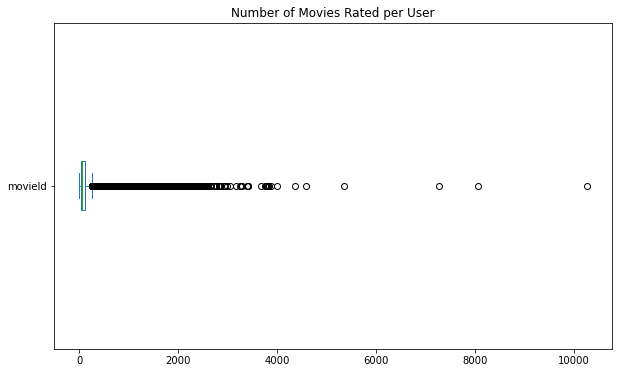

In [35]:
rating_df.groupby('userId')['movieId'].count().plot(
    kind='box',
    figsize=(10, 6),
    vert=False,
    title='Number of Movies Rated per User'
)
# plt.show()

In [36]:
# Calculate number of reviews per user
user_review_counts = rating_df.groupby('userId')['movieId'].count()

# Compute IQR thresholds
Q1 = user_review_counts.quantile(0.25)
Q3 = user_review_counts.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

In [37]:
upper_bound

265.5

In [38]:
rating_df = rating_df[rating_df.groupby('userId').movieId.transform('size') <268]

<AxesSubplot:title={'center':'Number of Movies Rated per User'}>

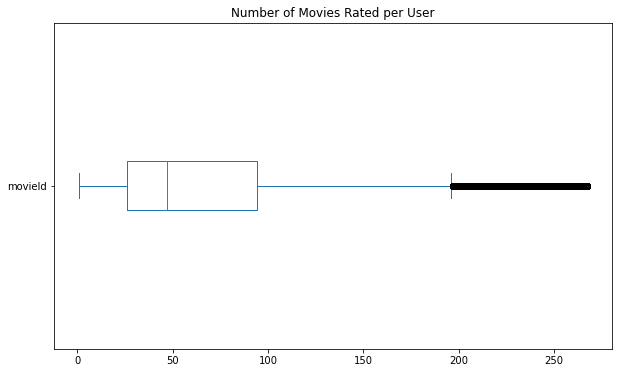

In [39]:
rating_df.groupby('userId')['movieId'].count().plot(
    kind='box',
    figsize=(10, 6),
    vert=False,
    title='Number of Movies Rated per User'
)

<AxesSubplot:ylabel='Frequency'>

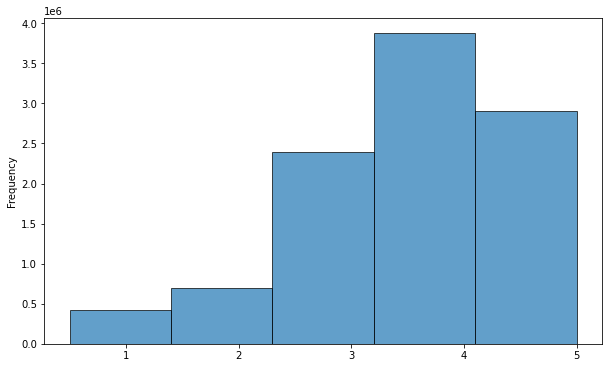

In [40]:
rating_df['rating'].plot(
    kind='hist',
    bins=5,  # For discrete ratings (1–5)
    figsize=(10, 6),
    edgecolor='black',
    alpha=0.7
)

In [41]:
rating_df.to_csv('rating_df.csv', index=False)
rating_df

,userId,movieId,rating,timestamp
0,1.0,342.0,5.0,2006-05-17 20:34:04
2,4.0,342.0,4.0,2019-11-17 02:14:58
3,5.0,342.0,4.0,1996-04-29 18:55:55
4,7.0,342.0,4.0,1996-06-22 16:58:50
5,8.0,342.0,5.0,1998-03-21 19:15:13
...,...,...,...,...
154416,168183.0,28279.0,3.0,2008-01-29 23:50:05
154448,818517.0,28452.0,1.0,2024-01-31 13:42:34
154451,1696664.0,28452.0,3.0,2011-08-09 14:22:55
154454,172902.0,28452.0,3.0,2008-02-05 16:41:50
